<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/12_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `12-deepfake.ipynb`

# Variational autoencoder

In [1]:
!pip install --upgrade gdown

Requirement already up-to-date: gdown in /usr/local/lib/python3.6/dist-packages (3.12.2)


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists


**CelebA dataset**  
공식 구글 드라이브가 사용용량으로 다운로드가 불가능한 경우가 있습니다.  
미러 링크 등을 이용하시면 됩니다.  


In [3]:
import gdown
md5 = '00d2c5bc6d35e252742224ab0c1e8fcb'  
# official download link
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
# mirror url
url = 'https://drive.google.com/uc?id=1vsObPMdbOQwysIb-XulliKXqRSKrw6Iq'
output = '/mydrive/img_align_celeba.zip'
gdown.cached_download(url, output, md5=md5)


Computing MD5: /mydrive/img_align_celeba.zip
MD5 matches: /mydrive/img_align_celeba.zip


'/mydrive/img_align_celeba.zip'

CelebA attribute data

In [4]:
import gdown
md5 = '4414d5bdd90f37e4a8548c501e098835'  
# official download link
url = 'https://drive.google.com/uc?id=1epcRzi5e2IzuWhAMNaigYtyRhwUq72-2'
output = '/mydrive/list_attr_celeba.csv'
gdown.cached_download(url, output, md5=md5)

Computing MD5: /mydrive/list_attr_celeba.csv
MD5 matches: /mydrive/list_attr_celeba.csv


'/mydrive/list_attr_celeba.csv'

In [5]:
!mkdir -p vae_data/celeb
!mkdir -p vae_data/weights

In [6]:
!unzip /mydrive/img_align_celeba.zip -d vae_data/celeb

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: vae_data/celeb/img_align_celeba/197601.jpg  
 extracting: vae_data/celeb/img_align_celeba/197602.jpg  
 extracting: vae_data/celeb/img_align_celeba/197603.jpg  
 extracting: vae_data/celeb/img_align_celeba/197604.jpg  
 extracting: vae_data/celeb/img_align_celeba/197605.jpg  
 extracting: vae_data/celeb/img_align_celeba/197606.jpg  
 extracting: vae_data/celeb/img_align_celeba/197607.jpg  
 extracting: vae_data/celeb/img_align_celeba/197608.jpg  
 extracting: vae_data/celeb/img_align_celeba/197609.jpg  
 extracting: vae_data/celeb/img_align_celeba/197610.jpg  
 extracting: vae_data/celeb/img_align_celeba/197611.jpg  
 extracting: vae_data/celeb/img_align_celeba/197612.jpg  
 extracting: vae_data/celeb/img_align_celeba/197613.jpg  
 extracting: vae_data/celeb/img_align_celeba/197614.jpg  
 extracting: vae_data/celeb/img_align_celeba/197615.jpg  
 extracting: vae_data/celeb/img_align_celeba/197616.jpg  
 extracting: vae_data/celeb/img_alig

In [11]:
!cp /mydrive/list_attr_celeba.csv vae_data/celeb

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob

In [13]:
SAVE_FOLDER = 'vae_data'
DATA_FOLDER = SAVE_FOLDER + '/celeb/'

INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)

mode =  'build' #'load' #
#mode =  'load' 

**학습용 Data Generator**

In [14]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202599 images belonging to 1 classes.


**Sampling 레이어**  
standard normal distritubion인 $\epsilon$ 샘플링으로부터   
$\mu$와 $\sigma$의 정규분포를 생성하는 레이어  
$ N(\mu, \sigma) = \mu + \sigma N(0, 1) = \mu + \sigma\epsilon$  

In [18]:
class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

**Encoder 모델 정의**  
Latent space의 차원: 200

In [19]:
z_dim = 200
r_loss_factor = 10000

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

**Decoder 모델 정의**


In [20]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t0 (Conv2DTrans (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0   

**Variational Autoencoder 모델 정의**  
`keras.Model` 클래스를 상속받아서 새로 정의함  

$D_{KL}(p\parallel q)={1\over 2}\left(\sigma^2+\mu^2-2\log\sigma-1 \right )$  

In [21]:

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                #tf.square(data - reconstruction)
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

In [22]:
LEARNING_RATE = 0.0005
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

save_folder = os.path.join(SAVE_FOLDER, 'weights')

VAE = VAEModel(encoder, decoder)
VAE.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [23]:
MODE = 'build'
#MODE = 'load'

if MODE == 'load':
    #ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    VAE.load_weights(save_folder+'/'+'checkpoint')

**Train**

In [24]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=1, step_size=1)
callbacks_list = [checkpoint, lr_sched]

VAE.fit(
    data_flow,
    shuffle=True,
    epochs=EPOCHS,
    steps_per_epoch = NUM_IMAGES / BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/200
1214/6331 [====>.........................] - ETA: 3:34 - loss: 5418.3267 - reconstruction_loss: 5315.5548 - kl_loss: 102.7719

KeyboardInterrupt: ignored

학습이 완료된 모델 weights 저장

In [ ]:
x = np.random.rand(1,128,128,3)
VAE.predict(x)
VAE.save(save_folder)

In [ ]:
!mkdir -p /mydrive/vae
!cp -r vae_data/weights /mydrive/vae

미리 학습된 weights 다운로드

In [25]:
#md5 = 'f503e59c23309a6f3f6348befc0ecde0'  
#url = 'https://drive.google.com/uc?id=15C6ad4coHKqbh5mtPGwreub5pX_Mnw-f'
#output = 'vae_weights2.tar.gz'

md5 = 'b387a8f59bd8bc09ee1eb12a80294379'  
url = 'https://drive.google.com/uc?id=19m6cQVNqXRhD6iEGkjA8ZZcOdev_b2V1'
output = 'vae_weights.tar.gz'

gdown.cached_download(url, output, md5=md5)

Cached Downloading: vae_weights.tar.gz
Downloading...
From: https://drive.google.com/uc?id=19m6cQVNqXRhD6iEGkjA8ZZcOdev_b2V1
To: /root/.cache/gdown/tmp05frd_5q/dl
59.2MB [00:00, 285MB/s]

Computing MD5: vae_weights.tar.gz
MD5 matches: vae_weights.tar.gz


'vae_weights.tar.gz'

weights 압축 해제

In [27]:
!tar xvzf vae_weights.tar.gz -C vae_data

weights/
weights/keras_metadata.pb
weights/checkpoint.data-00000-of-00001
weights/checkpoint.index
weights/variables/
weights/variables/variables.data-00000-of-00001
weights/variables/variables.index
weights/saved_model.pb
weights/checkpoint
weights/assets/


weights 로드

In [28]:
VAE.load_weights(save_folder+'/'+'checkpoint')

## VAE 분석

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

vae = VAE


In [30]:
DATA_FOLDER = './vae_data/celeb/'
IMAGE_FOLDER = './vae_data/celeb/img_align_celeba/'

In [31]:
class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size
                , class_mode='raw'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow

In [32]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [33]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**이미지 복원**

Found 202599 validated image filenames.


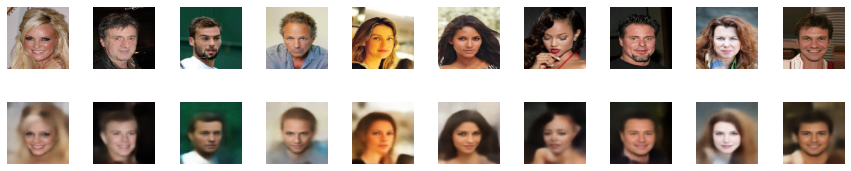

In [34]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

_,_,z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

**새로 얼굴 생성하기**

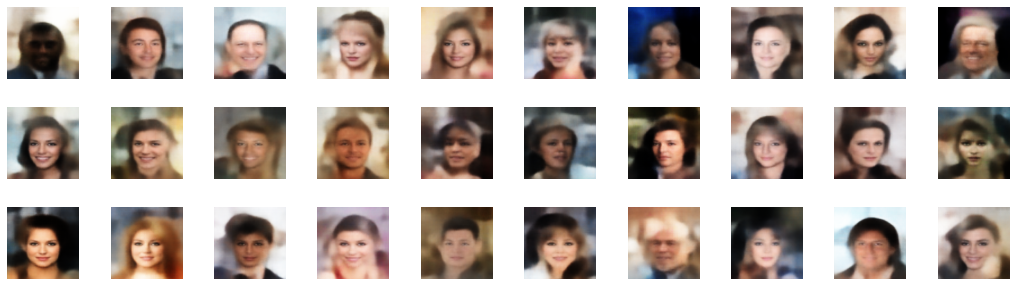

In [38]:
z_dim = 200
n_to_show = 30

znew = np.random.normal(size = (n_to_show,z_dim))/1

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [39]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        _,_,z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   

In [40]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

In [41]:
BATCH_SIZE = 500
# attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
# mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
# smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
# lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
# young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
# male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
# blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
30    : 3.552    : 0.738    : 3.637    : 3.637
61    : 2.158    : 0.436    : 2.843    : -0.794
88    : 1.03    : 0.273    : 2.493    : -0.35
124    : 0.826    : 0.187    : 2.315    : -0.178
160    : 0.562    : 0.153    : 2.306    : -0.009
189    : 0.43    : 0.136    : 2.222    : -0.084
213    : 0.38    : 0.101    : 2.221    : -0.001
239    : 0.317    : 0.092    : 2.217    : -0.003
275    : 0.346    : 0.08    : 2.18    : -0.037
317    : 0.293    : 0.073    : 2.154    : -0.026
346    : 0.213    : 0.063    : 2.138    : -0.016
373    : 0.225    : 0.059    : 2.123    : -0.015
396    : 0.166    : 0.049    : 2.095    : -0.028
419    : 0.163    : 0.051    : 2.103    : 0.008
449    : 0.184    : 0.048    : 2.064    : -0.039
490    : 0.194    : 0.044    : 2.071    : 0.007
525    : 0.167    : 0.037    : 2.061    : -0.01
559    : 0.156    : 0.034    : 2.058    : -0.003
606    : 0.167    : 0

Eyeglasses Vector


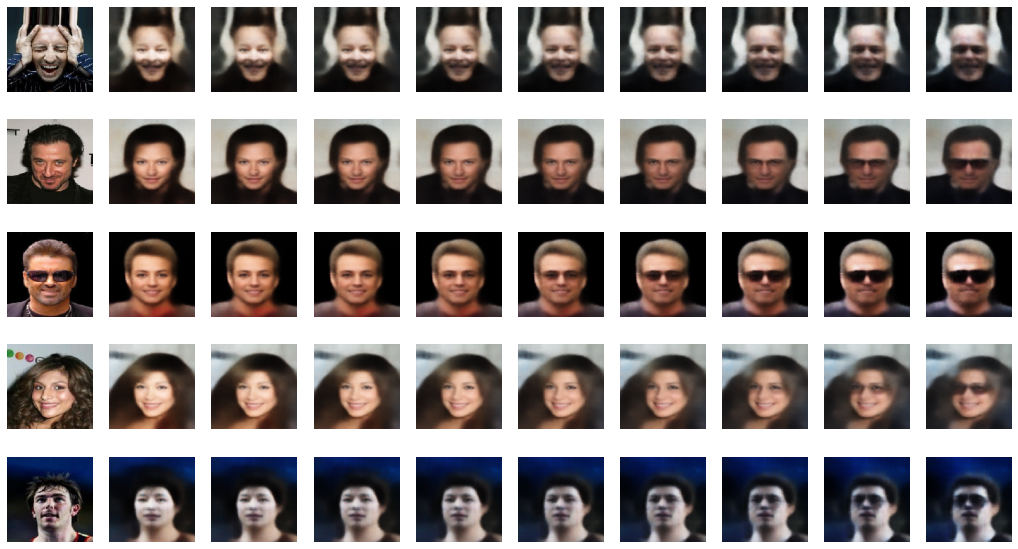

In [43]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [44]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


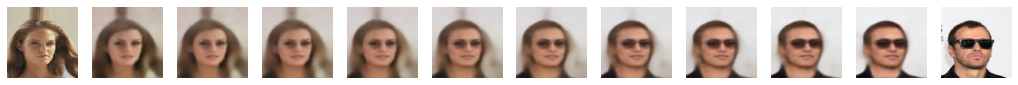

In [45]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


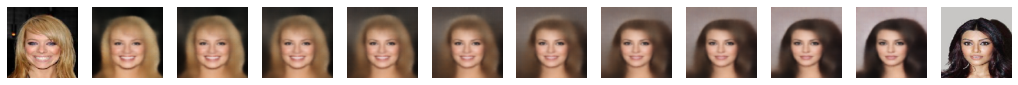

In [46]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


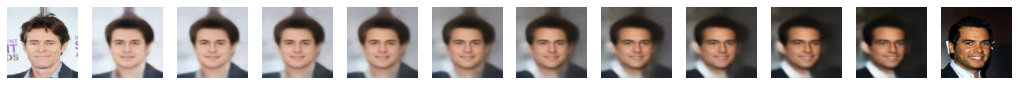

In [47]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

# Face swapping

Original source code from:  
https://github.com/EXJUSTICE/DeepFake_FaceSwap  

In [48]:
!git clone -b tensorflow2.update --single-branch https://github.com/shevious/DeepFake_FaceSwap.git --depth=1

fatal: destination path 'DeepFake_FaceSwap' already exists and is not an empty directory.


In [49]:
%cd DeepFake_FaceSwap

/content/DeepFake_FaceSwap


In [50]:
!mkdir -p obama-cut
!mkdir -p clinton-cut
!mkdir -p saved_model
!mkdir -p test

In [51]:
!pip install face_recognition
!pip install scandir

In [52]:
import cv2
from pathlib import Path
import face_recognition
from lib_1.PluginLoader import PluginLoader
from lib_1.faces_detect import detect_faces
from lib_1.FaceFilter import FaceFilter
import os

In [53]:
input_directory="obama-jpg"
output_directory="obama-cut"
filter_file = 'filter/obamafilter.jpg'

In [54]:
def load_filter():
    #filter_file = '../content/filter/obamafilter.jpg' # TODO Change argument here depending on what youre trying to extract
    if os.path.exists(filter_file):
        print('Loading reference image for filtering')
        return FaceFilter(filter_file)
    else:
        print("Filter not detected")

def get_faces(image):
    faces_count = 0
    filterDeepFake = load_filter()

    for face in detect_faces(image):

        if filterDeepFake is not None and not filterDeepFake.check(face):
            print('Skipping not recognized face!')
            continue


        yield faces_count, face

In [55]:

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

extractor_name = "Align" # TODO Pass as argument
extractor = PluginLoader.get_extractor(extractor_name)()

Loading Extract from Extract_Align plugin...


**얼굴 이미지 추출**

In [56]:
"""

#Single Example test

example  ="../content/data/CR_2012.jpg"


image = cv2.imread(example)

for idx, face in get_faces(image):
           resized_image = extractor.extract(image, face, 256)
           output_file = output_directory+"/"+str(Path(example).stem)
           cv2.imwrite(str(output_file) + str(idx) + Path(example).suffix, resized_image)
"""
#Simply iterating over the folder is insufficient, imread needs paths, so create them into a list.


def find_all_files(directory):
    for root, dirs, files in os.walk(directory):

        for file in files:
            p=os.path.join(root, file)
            p=p.split("/")[len(p.split("/"))-2]
            name, ext = os.path.splitext(p)

            yield os.path.join(root, file)

folder_img = find_all_files(input_directory)
try:
    for filename in folder_img:
        image = cv2.imread(filename)
        print(filename)
        for idx, face in get_faces(image):
            print('extractor')
            resized_image = extractor.extract(image, face, 256)
            output_file = output_directory+"/"+str(Path(filename).stem)
            print('imwrite')
            cv2.imwrite(str(output_file) + str(idx) + Path(filename).suffix, resized_image)

except Exception as e:
    print('Failed to extract from image: {}. Reason: {}'.format(filename, e))

input_directory="clinton-jpg"
output_directory="clinton-cut"
filter_file = 'filter/clintonfilter.jpg'

folder_img = find_all_files(input_directory)
try:
    for filename in folder_img:
        image = cv2.imread(filename)
        print(filename)
        for idx, face in get_faces(image):
            print('extractor')
            resized_image = extractor.extract(image, face, 256)
            output_file = output_directory+"/"+str(Path(filename).stem)
            print('imwrite')
            cv2.imwrite(str(output_file) + str(idx) + Path(filename).suffix, resized_image)

except Exception as e:
    print('Failed to extract from image: {}. Reason: {}'.format(filename, e))

obama-jpg/159.jpg
Loading reference image for filtering
-----
check
[0.35292288]
extractor
imwrite
obama-jpg/015.jpg
Loading reference image for filtering
-----
check
[0.31433079]
extractor
imwrite
obama-jpg/039.jpg
Loading reference image for filtering
-----
check
[0.40031424]
extractor
imwrite
obama-jpg/161.jpg
Loading reference image for filtering
-----
check
[0.44650184]
extractor
imwrite
obama-jpg/074.jpg
Loading reference image for filtering
-----
check
[0.31186847]
extractor
imwrite
obama-jpg/060.jpg
Loading reference image for filtering
-----
check
[0.32304186]
extractor
imwrite
obama-jpg/141.jpg
Loading reference image for filtering
-----
check
[0.4207712]
extractor
imwrite
obama-jpg/007.jpg
Loading reference image for filtering
-----
check
[0.33859353]
extractor
imwrite
obama-jpg/099.jpg
Loading reference image for filtering
-----
check
[0.43965448]
extractor
imwrite
obama-jpg/102.jpg
Loading reference image for filtering
-----
check
[0.2835247]
extractor
imwrite
obama-jpg/17

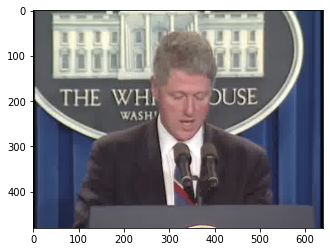

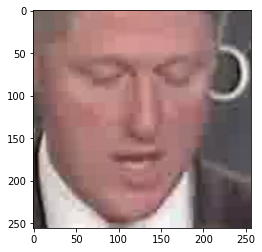

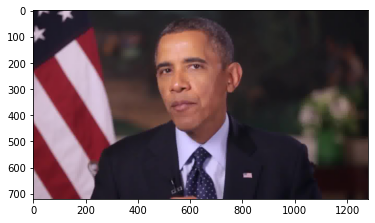

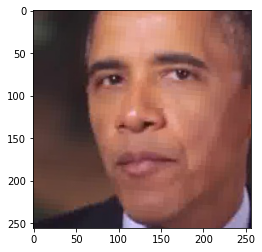

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

img = mp_image.imread('clinton-jpg/076.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('clinton-cut/0760.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('obama-jpg/076.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('obama-cut/0760.jpg')
plt.imshow(img)
plt.show()

## 학습하기

In [58]:
import gdown
md5 = 'd1b5f39e88b70cd3661b73b36f296586'  
# pretrained weights for speed up
url = 'https://drive.google.com/uc?id=1biKvZSxV-Dx9mUX-UMaFcZ6J8OMQ9MHQ'
output = 'weights2.zip'
gdown.cached_download(url, output, md5=md5)

Cached Downloading: weights2.zip
Downloading...
From: https://drive.google.com/uc?id=1biKvZSxV-Dx9mUX-UMaFcZ6J8OMQ9MHQ
To: /root/.cache/gdown/tmpfyd8k3yo/dl
304MB [00:04, 62.8MB/s]


Computing MD5: weights2.zip
MD5 matches: weights2.zip


'weights2.zip'

In [59]:
!unzip weights2.zip

Archive:  weights2.zip
   creating: weight/
  inflating: weight/decoder_A.h5     
  inflating: weight/decoder_B.h5     
  inflating: weight/encoder.h5       


In [60]:
import cv2
import numpy
import time

from pathlib import Path
from scandir import scandir

from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam

from lib_1.PixelShuffler import PixelShuffler
import time
import numpy
from lib_1.training_data import minibatchAB, stack_images

In [62]:

sav_Model="saved_model"
pretrained_weight="weight"
# 계속해서 train할 경우 아래의 저장 폴더를 이용
#pretrained_weight="saved_model"
image_actor_A_directory="obama-cut" #ORIGINAL
image_actor_B_directory="clinton-cut" #TARGET TO REPLACE WITH
batch_size=32
save_interval=500
ENCODER_DIM = 1024


#DON'T MODIFY
image_extensions = [".jpg", ".jpeg", ".png"]
encoderH5 = '/encoder.h5'
decoder_AH5 = '/decoder_A.h5'
decoder_BH5 = '/decoder_B.h5'
IMAGE_SHAPE = (64, 64, 3)

In [63]:
class dfModel():
    def __init__(self):
        self.model_dir = sav_Model
        self.pretrained_weight=pretrained_weight
        self.encoder = self.Encoder()
        self.decoder_A = self.Decoder()
        self.decoder_B = self.Decoder()

        self.initModel()

    def initModel(self):
        optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999) #orig adam 5e-5
        x = Input(shape=IMAGE_SHAPE)

        self.autoencoder_A = KerasModel(x, self.decoder_A(self.encoder(x)))
        self.autoencoder_B = KerasModel(x, self.decoder_B(self.encoder(x)))
        print(self.encoder.summary())
        print(self.decoder_A.summary())

        self.autoencoder_A.compile(optimizer=optimizer, loss='mean_absolute_error')
        self.autoencoder_B.compile(optimizer=optimizer, loss='mean_absolute_error')

    def converter(self, swap):
        autoencoder = self.autoencoder_B if not swap else self.autoencoder_A
        return lambda img: autoencoder.predict(img)

    def conv(self, filters):
        def block(x):
            x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            return x
        return block

    def upscale(self, filters):
        def block(x):
            x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            x = PixelShuffler()(x)
            #Pixelshufflers job here is analoguous to upsampling2d
            return x
        return block

    #Note how no maxpooling after every layer here, we are generating a WARPED image, not a lower dimensional representation first.
    def Encoder(self):
        input_ = Input(shape=IMAGE_SHAPE)
        x = input_
        x = self.conv(128)(x)
        x = self.conv(256)(x)
        x = self.conv(512)(x)
        x = self.conv(1024)(x)
        x = Dense(ENCODER_DIM)(Flatten()(x))
        x = Dense(4 * 4 * 1024)(x)
        #Passed flattened X input into 2 dense layers, 1024 and 1024*4*4
        x = Reshape((4, 4, 1024))(x)
        #Reshapes X into 4,4,1024
        x = self.upscale(512)(x)
        return KerasModel(input_, x)

    def Decoder(self):
        input_ = Input(shape=(8, 8, 512))
        x = input_
        x = self.upscale(256)(x) #Actually 1024 given filters*4
        x = self.upscale(128)(x) #Actually 512
        x = self.upscale(64)(x) #Actually 256
        x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
        return KerasModel(input_, x)

    def load(self, swapped):
        (face_A,face_B) = (decoder_AH5, decoder_BH5) if not swapped else (decoder_BH5, decoder_AH5)
        try:
            self.encoder.load_weights(self.pretrained_weight + encoderH5)
            self.decoder_A.load_weights(self.pretrained_weight + face_A)
            self.decoder_B.load_weights(self.pretrained_weight + face_B)
            print('loaded model weights')
            return True
        except Exception as e:
            print('Failed loading existing training data.')
            print(e)
            return False
            
    def save_weights(self):
        self.encoder.save_weights(self.model_dir + encoderH5)
        self.decoder_A.save_weights(self.model_dir + decoder_AH5)
        self.decoder_B.save_weights(self.model_dir + decoder_BH5)
        print('saved model weights')


In [65]:
class Trainer():
    def __init__(self, model, fn_A, fn_B, batch_size=64):
        self.batch_size = batch_size
        self.model = model
        self.images_A = minibatchAB(fn_A, self.batch_size)
        self.images_B = minibatchAB(fn_B, self.batch_size)

    def train_one_step(self, iter):
        epoch, warped_A, target_A = next(self.images_A)
        epoch, warped_B, target_B = next(self.images_B)

        loss_A = self.model.autoencoder_A.train_on_batch(warped_A, target_A)
        loss_B = self.model.autoencoder_B.train_on_batch(warped_B, target_B)
        print("[{0}] [#{1:05d}] loss_A: {2:.5f}, loss_B: {3:.5f}".format(time.strftime("%H:%M:%S"), iter, loss_A, loss_B),
            end='\r')

In [66]:
def get_image_paths(directory):
    return [x.path for x in scandir(directory) if
     any(map(lambda ext: x.name.lower().endswith(ext), image_extensions))]

In [67]:
model = dfModel()
model.load(swapped=False)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 128)       9728      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         3277312   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 512)        

True

In [68]:
images_A = get_image_paths(image_actor_A_directory)
images_B = get_image_paths(image_actor_B_directory)
trainer = Trainer(model,images_A,images_B,batch_size=batch_size)

for epoch in range(0, 1000000):

    save_iteration = epoch % save_interval == 0

    trainer.train_one_step(epoch)

    if save_iteration:
        print('epoch =', epoch)
        model.save_weights()

epoch = 0
saved model weights


KeyboardInterrupt: ignored

## 생성하기

In [69]:
import gdown
md5 = 'b2b747e22727313ed5f64323a6e041ee'  
# 학습하기
url = 'https://drive.google.com/uc?id=1DbGpF_nhVJMeRaVcSVZRh1I1xfp7_dAj'
output = 'saved_model_obama.tar.gz'
gdown.cached_download(url, output, md5=md5)

Computing MD5: saved_model_obama.tar.gz
MD5 matches: saved_model_obama.tar.gz


'saved_model_obama.tar.gz'

In [70]:
!tar xvzf saved_model_obama.tar.gz

saved_model_obama/
saved_model_obama/encoder.h5
saved_model_obama/decoder_A.h5
saved_model_obama/decoder_B.h5


In [71]:

import cv2
import re
from pathlib import Path
from lib_1.utils import BackgroundGenerator, get_image_paths, get_folder
from lib_1.faces_detect import detect_faces
from lib_1.FaceFilter import FaceFilter
from tqdm import tqdm
from lib_1.PluginLoader import PluginLoader

#os.run_line_magic('pylab', 'inline')
import matplotlib.pyplot as plt

from keras.models import Model as KerasModel
from keras.layers import Input, Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from lib_1.PixelShuffler import PixelShuffler

In [73]:
# We define the caracteristics of our network:
#    * model_dir: the location of the model (it needs to be the absolute path)
#    * conv_name: the kind of converter to use ("Masked" or "Adjust")
#    * swap_model: Swap the model. Instead of A -> B, swap B -> A.
#    * blur_size: Blur size. (it only work for Masked converter)
#    * seamless_clone: Seamless mode
#    * mask_type: the type of mask to use to replace faces.("rect", "facehull", "facehullandrect")
#    * erosion_kernel_size: the erosion kernel size. (it only work for the masked converter)
#    * smooth_mask: use Smooth mask (it only work for the Adjust converter)
#    * avg_color_adjust: average the color (it only work for the Adjust converter)
#    * input_dir: the location of the input images (it needs to be the absolute path)
#    * output_dir: the location of the output images (it needs to be the absolute path)
#    * filter_image: the image that will be used to filter faces 
#    
# I invite you to try different parameter until you get a satifying result.

#model_dir="saved_model"
#model_dir="weights" # 누구일까요?
model_dir='saved_model_obama'
conv_name = "Masked"
swap_model= False
blur_size=2
#seamless_clone=False
seamless_clone=True
mask_type="facehullandrect"
erosion_kernel_size=None
smooth_mask=True
avg_color_adjust=True
input_dir="obama-jpg"
output_dir="test"
filter_image="filter/obamafilter.jpg"

In [74]:
#DONT MODIFY 
IMAGE_SHAPE = (64, 64, 3)
ENCODER_DIM = 1024
encoderH5 = '/encoder.h5'
decoder_AH5 = '/decoder_A.h5'
decoder_BH5 = '/decoder_B.h5'
model_name = "Original" # TODO Pass as argument

In [75]:
def load_filter():
    filter_file = filter_image # TODO Pass as argument
    if Path(filter_file).exists():
        print('Loading reference image for filtering')
        return FaceFilter(filter_file)

def get_faces(image):
    faces_count = 0
    filterDeepFake = load_filter()
    extractor = PluginLoader.get_extractor("Align")()
    for face in detect_faces(image):
        if filterDeepFake is not None and not filterDeepFake.check(face):
            print('Skipping not recognized face!')
            continue
        resized_image = extractor.extract(image, face, 256)

        yield faces_count, face
        faces_count +=1

def get_list_images_faces():
    input_list = get_image_paths(input_dir)
    listFile=[]
    for filename in tqdm(input_list):
        listFile.append(filename)
    for filename in listFile:
        image = cv2.imread(filename)
        yield filename, image, get_faces(image)

`converter.patch_image(image, face)` 함수를 통하여 모델을 실행  


In [76]:
def convert(converter, item):
    try:
        (filename, image, faces) = item
        for idx, face in faces:
            image1 = converter.patch_image(image, face)
        output_file = str(output_dir)+ str("/")+ str(Path(filename).name)

        cv2.imwrite(str(output_file), image1)
    except Exception as e:
        print('Failed to convert image: {}. Reason: {}'.format(filename, e))

`lib_1/Convert_Masked.py` 발췌본

In [15]:
import cv2
import numpy

from lib_1.aligner import get_align_mat

class Convert():
    def __init__(self, encoder, blur_size=2, seamless_clone=False, mask_type="facehullandrect", erosion_kernel_size=None, **kwargs):
        self.encoder = encoder

        self.erosion_kernel = None
        if erosion_kernel_size is not None:
            self.erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erosion_kernel_size,erosion_kernel_size))

        self.blur_size = blur_size
        self.seamless_clone = seamless_clone
        self.mask_type = mask_type.lower() # Choose in 'FaceHullAndRect','FaceHull','Rect'

    def patch_image( self, image, face_detected ):
        size = 64
        image_size = image.shape[1], image.shape[0]

        mat = numpy.array(get_align_mat(face_detected)).reshape(2,3) * size

        new_face = self.get_new_face(image,mat,size)

        image_mask = self.get_image_mask( image, new_face, face_detected, mat, image_size )

        return self.apply_new_face(image, new_face, image_mask, mat, image_size, size)

    def apply_new_face(self, image, new_face, image_mask, mat, image_size, size):
        base_image = numpy.copy( image )
        new_image = numpy.copy( image )

        outImage = None
        if self.seamless_clone:
            masky,maskx = cv2.transform( numpy.array([ size/2,size/2 ]).reshape(1,1,2) ,cv2.invertAffineTransform(mat) ).reshape(2).astype(int)
            outimage = cv2.seamlessClone(new_image.astype(numpy.uint8),base_image.astype(numpy.uint8),(image_mask*255).astype(numpy.uint8),(masky,maskx) , cv2.NORMAL_CLONE )
        else:
            foreground = cv2.multiply(image_mask, new_image.astype(float))
            background = cv2.multiply(1.0 - image_mask, base_image.astype(float))
            outimage = cv2.add(foreground, background)

        return outimage

    def get_new_face(self, image, mat, size):
        face = cv2.warpAffine( image, mat, (size,size) )
        face = numpy.expand_dims( face, 0 )
        new_face = self.encoder( face / 255.0 )[0]

        return numpy.clip( new_face * 255, 0, 255 ).astype( image.dtype )

    def get_image_mask(self, image, new_face, face_detected, mat, image_size):

        face_mask = numpy.zeros(image.shape,dtype=float)
        if 'rect' in self.mask_type:
            face_src = numpy.ones(new_face.shape,dtype=float)
            cv2.warpAffine( face_src, mat, image_size, face_mask, cv2.WARP_INVERSE_MAP, cv2.BORDER_TRANSPARENT )

        hull_mask = numpy.zeros(image.shape,dtype=float)
        if 'hull' in self.mask_type:
            hull = cv2.convexHull( numpy.array( face_detected.landmarksAsXY() ).reshape((-1,2)).astype(int) ).flatten().reshape( (-1,2) )
            cv2.fillConvexPoly( hull_mask,hull,(1,1,1) )

        if self.mask_type == 'rect':
            image_mask = face_mask
        elif self.mask_type == 'faceHull':
            image_mask = hull_mask
        else:
            image_mask = ((face_mask*hull_mask))
            
        if self.erosion_kernel is not None:
            image_mask = cv2.erode(image_mask,self.erosion_kernel,iterations = 1)

        if self.blur_size!=0:
            image_mask = cv2.blur(image_mask,(self.blur_size,self.blur_size))

        return image_mask

학습모델과 동일한 생성모델  
(load에서 weight가져오는 부분만 다름)  

In [77]:
class Model():
    def __init__(self):

        self.model_dir = model_dir
        self.encoder = self.Encoder()
        self.decoder_A = self.Decoder()
        self.decoder_B = self.Decoder()

        self.initModel()

    def initModel(self):
        optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999)
        x = Input(shape=IMAGE_SHAPE)

        self.autoencoder_A = KerasModel(x, self.decoder_A(self.encoder(x)))
        self.autoencoder_B = KerasModel(x, self.decoder_B(self.encoder(x)))

        self.autoencoder_A.compile(optimizer=optimizer, loss='mean_squared_error')
        self.autoencoder_B.compile(optimizer=optimizer, loss='mean_squared_error')

    def converter(self, swap):
        autoencoder = self.autoencoder_B if not swap else self.autoencoder_A
        return lambda img: autoencoder.predict(img)

    def conv(self, filters):
        def block(x):
            x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            return x
        return block

    def upscale(self, filters):
        def block(x):
            x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            x = PixelShuffler()(x)
            return x
        return block


    def Encoder(self):
        input_ = Input(shape=IMAGE_SHAPE)
        x = input_
        x = self.conv(128)(x)
        x = self.conv(256)(x)
        x = self.conv(512)(x)
        x = self.conv(1024)(x)
        x = Dense(ENCODER_DIM)(Flatten()(x))
        x = Dense(4 * 4 * 1024)(x)
        x = Reshape((4, 4, 1024))(x)
        x = self.upscale(512)(x)
        return KerasModel(input_, x)

    def Decoder(self):
        input_ = Input(shape=(8, 8, 512))
        x = input_
        x = self.upscale(256)(x)
        x = self.upscale(128)(x)
        x = self.upscale(64)(x)
        x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
        return KerasModel(input_, x)

    def load(self, swapped):
        (face_A,face_B) = (decoder_AH5, decoder_BH5) if not swapped else (decoder_BH5, decoder_AH5)

        try:
            self.encoder.load_weights(self.model_dir + encoderH5)
            self.decoder_A.load_weights(self.model_dir + face_A)
            self.decoder_B.load_weights(self.model_dir + face_B)
            print('loaded model weights')
            return True
        except Exception as e:
            print('Failed loading existing training data.')
            print(e)
            return False

    def save_weights(self):
        self.encoder.save_weights(self.model_dir + encoderH5)
        self.decoder_A.save_weights(self.model_dir + decoder_AH5)
        self.decoder_B.save_weights(self.model_dir + decoder_BH5)
        print('saved model weights')

3단계로 face swap 진행:  
    1. `PluginLoader.get_model(model_name)(model_dir)`을 통하여 모델 선언    
    2. 앞에서 학습한 모델 weights를 로딩    
    3. 입력 영상으로부터 얼굴의 특징을 `get_list_images_faces`를 이용하여 추출  
    4. `convert(converter, item)`를 통하여 모델을 호출하고 mask를 이용한 face swapping 수행    


In [78]:
model = Model()
if not model.load(swap_model):
    print('Model Not Found! A valid model must be provided to continue!')
    exit(1)

faceswap_converter = PluginLoader.get_converter(conv_name)(model.converter(False),
    blur_size=blur_size,
    seamless_clone=seamless_clone,
    mask_type=mask_type,
    erosion_kernel_size=erosion_kernel_size,
    smooth_mask=smooth_mask,
    avg_color_adjust=avg_color_adjust
)

list_faces=get_list_images_faces()


batch = BackgroundGenerator(list_faces, 1)

for item in batch.iterator():
    convert(faceswap_converter, item)

100%|██████████| 182/182 [00:00<00:00, 414646.02it/s]

loaded model weights
Loading Convert from Convert_Masked plugin...
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----


check
[0.35292288]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.31433079]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.40031424]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.44650184]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.31186847]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.32304186]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.4207712]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.33859353]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.43965448]
Loading reference image for filtering
Loading Extract from Extract_Align plugin...
-----
check
[0.2835247]
Loading ref

In [79]:
!ls test

001.jpg  049.jpg  097.jpg  145.jpg
002.jpg  050.jpg  098.jpg  146.jpg
003.jpg  051.jpg  099.jpg  147.jpg
004.jpg  052.jpg  100.jpg  148.jpg
005.jpg  053.jpg  101.jpg  149.jpg
006.jpg  054.jpg  102.jpg  150.jpg
007.jpg  055.jpg  103.jpg  151.jpg
008.jpg  056.jpg  104.jpg  152.jpg
009.jpg  057.jpg  105.jpg  153.jpg
010.jpg  058.jpg  106.jpg  154.jpg
011.jpg  059.jpg  107.jpg  155.jpg
012.jpg  060.jpg  108.jpg  156.jpg
013.jpg  061.jpg  109.jpg  157.jpg
014.jpg  062.jpg  110.jpg  158.jpg
015.jpg  063.jpg  111.jpg  159.jpg
016.jpg  064.jpg  112.jpg  160.jpg
017.jpg  065.jpg  113.jpg  161.jpg
018.jpg  066.jpg  114.jpg  162.jpg
019.jpg  067.jpg  115.jpg  163.jpg
020.jpg  068.jpg  116.jpg  164.jpg
021.jpg  069.jpg  117.jpg  165.jpg
022.jpg  070.jpg  118.jpg  166.jpg
023.jpg  071.jpg  119.jpg  167.jpg
024.jpg  072.jpg  120.jpg  168.jpg
025.jpg  073.jpg  121.jpg  169.jpg
026.jpg  074.jpg  122.jpg  170.jpg
027.jpg  075.jpg  123.jpg  171.jpg
028.jpg  076.jpg  124.jpg  172.jpg
029.jpg  077.jpg  12

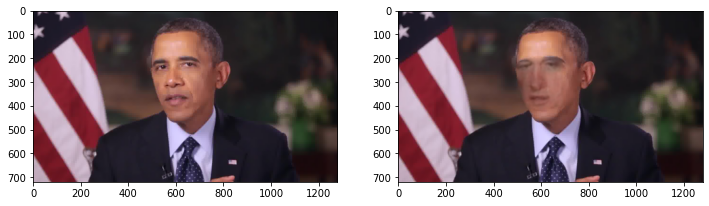

In [83]:
import matplotlib.image as mp_image
import matplotlib.pyplot as plt

img_path = '048.jpg'
orgface = mp_image.imread('obama-jpg/'+img_path)
newface = mp_image.imread('test/'+img_path)
plt.figure(figsize=(12,8))
plt.subplot('121')
plt.imshow(orgface)
plt.subplot('122')
plt.imshow(newface)
plt.show()

**동영상 만들기 개요**  
1. mp4 다운로드  
2. ffmpeg을 이용하여 모든 frame 추출  
   `ffmpeg -i ../obama.mp4 file%04d.jpg`  
3. faceswap 실행  
4. 변환된 이미지를 다시 동영상으로 인코딩  
   `ffmpeg -framerate 29.97 -pattern_type glob -i '*.jpg' ../obama-swap.mp4`  